In [1]:
#| default_exp skymaps
from nbdev.showdoc import show_doc
from utilities.ipynb_docgen import *

%load_ext autoreload
%autoreload 2
! date

Sun Dec 11 14:54:28 PST 2022


Plotting code 

* `HPmap` -- manage a HEALPix array
* `ait_plot` - make an  aitoff projection of the sky
* `SquareWCS` class for generating square images from all-sky healpix maps.



In [2]:
#| export
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import healpy

from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.io import fits

from wtlike.config import *
from wtlike.data_man import DataView
from wtlike.sources import findsource

valid = Config().valid;

## Aitoff projection

In [3]:
#| export
def _trans(*args):
    """ 
    Helper for AitoffFigure: Translate degrees to radians (cleaner if aitoff did it)
    Expect first arg or args to be:
    * a SkyCoord object (perhaps a list of positions)
    - or -
    *  lists of l, b in degrees
    - or -
    * a DataFrame with ra and dec columns
    """
    nargs = len(args)
    if nargs>0 and isinstance(args[0], SkyCoord):
        sc = args[0].galactic
        l, b = sc.l.deg, sc.b.deg
        rest = args[1:]
    elif nargs>0 and isinstance(args[0], pd.DataFrame):
        df = args[0]
        sc = SkyCoord(df.ra, df.dec, unit='deg', frame='fk5').galactic
        l, b = sc.l.deg, sc.b.deg
        rest = args[1:]
    elif nargs>1:
        l, b = args[:2]
        rest = args[2:]
    else:
        raise ValueError('Expect positional parameters l,b, or skycoord or DataFrame with ra,dec')

    # convert to radians 
    x  = -np.radians(np.atleast_1d(l))
    x[x<-np.pi] += 2*np.pi # equivalent to mod(l+pi,2pi)-pi I think
    y = np.radians(np.atleast_1d(b))
    return [x,y] + list(rest) 

In [4]:
#| export
class AitoffFigure():

    """ Implement plot and text conversion from (l,b) in degrees, or a SkyCoord.

    """
    def __init__(self, fig=None, figsize=(10,5)):
        self.fig = fig or plt.figure(figsize=figsize)
        if len(self.fig.axes)==0:
            ax=self.fig.add_subplot(111, projection='aitoff')
            ax.set(xticklabels=[], yticklabels=[], visible=True)
            ax.grid(color='grey')
        self.ax = self.fig.axes[0]
        assert self.ax.__class__.__name__ == 'AitoffAxesSubplot', 'expect figure to have aitoff Axes instance'

    def plot(self, *args, **kwargs):
        self.ax.plot(*_trans(*args), **kwargs)

    def text(self, *args, **kwargs):
        self.ax.text(*_trans(*args), **kwargs)

    def scatter(self, *args, **kwargs):
        return self.ax.scatter(*_trans(*args), **kwargs)

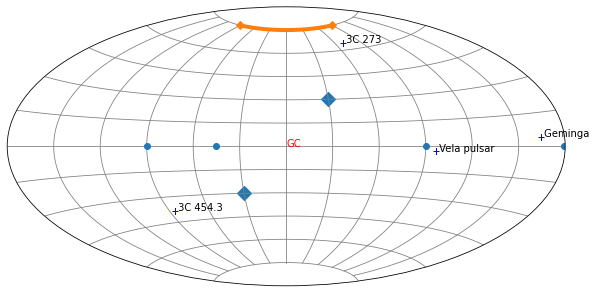

In [5]:
#| include: false

show_doc(AitoffFigure, title_level=3)
afig = AitoffFigure(figsize=(10,10))
l,b = [45,90, 181, 270], [0,0,0,0]
afig.plot(l,b,'o')
afig.text(0,0, 'GC', color='red')
afig.plot([-90,90], [75,75], 'D-', lw=4);
afig.scatter([30,-30], [-30,30], marker='D', s=100);
for name in ['Vela pulsar', 'Geminga', '3C 454.3', '3C 273']:
    sc = SkyCoord.from_name(name)
    afig.text(sc, ' '+name)
    afig.plot(sc, '+b')

## SquareWCS

In [6]:
#| export

class SquareWCS(WCS):
    """
    Create and use a WCS object

    - center : a SkyCoord that will be the center
    - size   : width and height of the display (deg)
    - pixsize [0.1] : pixel size
    - frame [None] : The frame is taken from the center SkyCoord, unless specified here --  only accept "galactic" or "fk5"
    - proj ["ZEA"] : projection to use
    
    To get the WCS properties from the generated Axes object (actually WCSAxesSubplot): ax.wcs.wcs.crval for (l,b)
    """

    def __init__(self, center, size, pixsize=0.1, frame=None, proj='ZEA', unit=''):
        """

        """
        if type(center)==str:
            center = SkyCoord.from_name(center)
        assert isinstance(center, SkyCoord), 'Expect SkyCoord'

        frame = frame or center.frame.name
        if frame=='galactic':
            lon, lat = center.galactic.l.deg, center.galactic.b.deg
            lon_name,lat_name = 'GLON','GLAT'
            self.axis_labels='$l$', '$b$'
        elif frame=='fk5':
            lon,lat = center.fk5.ra.deg, center.fk5.dec.deg
            lon_name, lat_name = 'RA--', 'DEC-'
            self.axis_labels = 'RA', 'Dec'
        else:
            raise Exception(f'Expect frame to be "galactic" or "fk5", not {frame}')

        nx=ny=naxis = int(size/pixsize) | 1 # make odd so central pixel has source in middle
        self.center = center
        self.frame=frame
        self.unit=unit
        self.galactic = frame=='galactic'
        super().__init__(
                         dict(
            NAXIS1=nx, CTYPE1=f'{lon_name}-{proj}', CUNIT1='deg', CRPIX1=nx//2+1, CRVAL1=lon, CDELT1=-pixsize,
            NAXIS2=ny, CTYPE2=f'{lat_name}-{proj}', CUNIT2='deg', CRPIX2=ny//2+1, CRVAL2=lat, CDELT2=pixsize, )
              )

    def _make_grid(self):
        # get coordinates of every pixel`
        nx, ny = self.array_shape
        pixlists = list(range(1,nx+1)),list(range(1,ny+1))
        cgrid = self.pixel_to_world(*np.meshgrid(*pixlists) )
        if not self.galactic:
            cgrid = cgrid.galactic
        lon, lat = (cgrid.l.deg, cgrid.b.deg)
        return lon, lat

    def plot_map(self, hmap, fig=None, axpos=111, figsize=(8,8),
             log=False, cmap='jet', colorbar=True, 
             unit='', vmin=None, vmax=None, cb_kw={},
             annotator=None, title=None, **kwargs):
        """
        Plot a map
        
        - hmap -- a HEALPix map
        - fig  [None] -- a Figure

        """

        import healpy as hp
        from matplotlib import colors

        wcs = self
        grid = self._make_grid();
        nside = hp.get_nside(hmap)

        # lon, lat = grid.l.deg, grid.b.deg
        ipix = hp.ang2pix(nside, *grid, lonlat=True)

        fig = fig or plt.figure(figsize=figsize)
        if type(axpos)==tuple:
            ax = fig.add_subplot(*axpos, projection=self)
        else:
            ax = fig.add_subplot(axpos, projection=self)
        ax = fig.axes[-1] ####  KLUGE
        if log:
            norm = colors.LogNorm(vmin=vmin,vmax=vmax)
            vmin=vmax=None
        else:
            norm = None
        ipix = hp.ang2pix(nside, *grid, lonlat=True)
        im = ax.imshow(hmap[ipix], cmap=cmap, origin='lower', 
                       norm=norm,  vmin=vmin, vmax=vmax);

        nx, ny = wcs.array_shape
        ax.set(xlabel=self.axis_labels[0], xlim=(-0.5, nx-0.5),
               ylabel=self.axis_labels[1], ylim=(-0.5, ny-0.5),
               title= title)
        ax.grid();
        if colorbar:
            ticklabels = cb_kw.pop('ticklabels', None)
            cb_kw.update(label=self.unit,)
            cb = plt.colorbar(im, ax=ax,  **cb_kw)
            if ticklabels is not None:
                cb.ax.set_yticklabels(ticklabels)
        if annotator is not None:
            # set the defalut transform
            ax.transAxes = ax.get_transform(self.frame)
            annotator(ax, self.frame)
        return fig

In [7]:
# #| code-fold: true

# @ipynb_doc
# def squaremap_demo(name, hpmap, size, vmin=10, vmax=1000):
#     r"""
#     ### Demonstrate SquareWCS
    
#     This looks at a region of the all-sky count map generated above.
    
#     Start with  a ${size}^\circ$ plot in Galactic coordinates, centered on the source "{name}".
    
#     The `SquareWCS.plot` function is called with a callback specified by a kwarg `annotator`.
#     Here the `annotate`  function identifies Geminga and the Crab.
#     {fig1}
    
#     Repeat, using the equatorial "fk5" frame for this one.
#     {fig2}
#     """

#     sc = findsource(name, gal=True)

#     swcs = SquareWCS(sc, size=90)

#     def annotate(ax, frame):
        
        
#         def source_lonlat(name, gal=True):            
#             sky = findsource(name, gal=gal)
#             if gal: return sky.galactic.l.deg, sky.galactic.b.deg
#             return sky.ra.deg, sky.dec.deg
        
#         tf =ax.get_transform(frame) # need the transformation from pixel to world
#         for name in ['Geminga', 'Crab pulsar']:
#             glb = source_lonlat(name, gal=frame=='galactic')
#             ax.scatter(*glb , transform=tf, s=500, edgecolor='black', facecolor='none') 
#             ax.text(*glb, '   '+name, color='black', transform=tf);

#     cb_kw = dict(ticks = [0.1, 1, 10, 100, 1000],
#                 ticklabels='0.1 1 10 100 1000'.split(), shrink=0.8)
    
#     fig1 = swcs.plot(hpmap,  log=True, vmin=vmin, vmax=vmax, unit='counts/pixel',
#               cb_kw=cb_kw, annotator = annotate)
    
#     swcsc = SquareWCS(sc.fk5, size=90)

#     fig2 = swcsc.plot(hpmap, log=True, vmin=vmin, vmax=vmax, unit='counts/pixel',
#           cb_kw=cb_kw, annotator=annotate)
#     return locals()

# if valid and hpm is not None: squaremap_demo('Crab pulsar', hpmap=hpm.map, size=90, fignum=1)

In [8]:
#| export
class FITSimage():
    """
    Manage a FITs image
    """
    def __init__(self, filename):
        from astropy.io import fits
        from astropy.wcs import WCS
        with  fits.open(filename) as hdulist:
            hdu = hdulist[0] 
            self.wcs = WCS(hdu.header)  
            self.data = hdu.data
            
    def plot(self, fig=None, title='', cmap='jet', vmin=None, vmax=None):
        """Make a plot
        """
        fig = fig or plt.figure(figsize=(6,6)) 
        ax = fig.add_subplot(projection=self.wcs)
        plt.imshow(self.data, cmap=cmap, vmin=vmin, vmax=vmax, origin='lower')
        # this needs to depend on type of coords!
        ax.set(xlabel='RA', ylabel='Dec', title=title);
        plt.colorbar(shrink=0.8)
        ax.grid(alpha=0.4)
        return ax
    
    def __call__(self, coord, badval=np.nan):
        """Return value(s) for SkyCoord value array
        
        """
        coord = np.atleast_1d(coord)
        xsize, ysize = self.data.shape
        x,y = np.array(self.wcs.world_to_array_index(coord) )  
        result = np.full(len(coord), badval)
        good = (x>=0) * (x<xsize) * (y>=0) * (y<ysize)
        result[good] = self.data[x[good], y[good]]
        return result if len(coord)>1 else result[0]

In [9]:
show_doc(FITSimage)

---

### FITSimage

>      FITSimage (filename)

Manage a FITs image

### FITSimage demo
This loads the FITS image file from astropy, contents, 
loads it with this class, then displays it:
<figure style="margin-left: 25px" title="Figure 1">   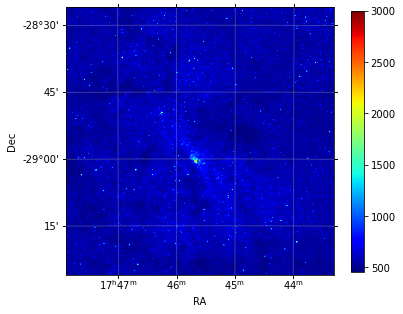 </figure>

An object of the class is a functor: the value at the GC is 564.


In [10]:
#| code-fold: true
@ipynb_doc
def fits_image_demo():
    """
    ### FITSimage demo
    This loads the FITS image file from astropy, {filename}, 
    loads it with this class, then displays it:
    {fig}
    
    An object of the class is a functor: the value at the GC is {gcval:.0f}.
    """

    from astropy.utils.data import get_pkg_data_filename
    fullfilename = get_pkg_data_filename('galactic_center/gc_2mass_k.fits') 
    filename = Path(fullfilename).name
    fi2 = FITSimage(fullfilename)
    fi2.plot();
    fig = plt.gcf()    
    gcval = fi2(SkyCoord(0,0,unit='deg',frame='galactic'))
    return locals()
fits_image_demo()

In [11]:
#| export
class HPmap(object):
    """
    Manage HEALPix array
    """
    def __init__(self,
            hpmap:'HEALPix array',
            name='',
            cblabel=None,
            unit='',
            sigma:'smooth parameter'=None,
            nest=False):
        """create from a HEALPix array
        """
        self.name = name
        self.cblabel = cblabel if cblabel is not None else unit
        self.unit = unit
        self.nside = healpy.get_nside(hpmap)
        # reorder as defaut RING if nest is set
        self.map = hpmap if not nest else healpy.reorder(hpmap, n2r=True)

        if sigma is not None:
            self.smooth(sigma)

    def __str__(self):
        return f'<{self.__class__.__name__}>, name "{self.name}" nside {self.nside} unit "{self.unit}"'
    def __repr__(self): return str(self)

    def __call__(self, sc:'SkyCoord') -> 'value[s]':
        """
        Return value of corresponding pixel(s)
        """
        sp = sc.spherical # avoid dependence on specific frame
        skyindex = healpy.ang2pix(self.nside, sp.lon.deg, sp.lat.deg, lonlat=True)
        return self.map[skyindex]

    def get_all_neighbors(self, pix):
        return healpy.get_all_neighbours(self.nside, pix)

    def smooth(self, sigma):
            self.map = healpy.smoothing(self.map, np.radians(sigma))

    @classmethod
    def from_FITS(cls, filename, *pars, **kwargs):
        with fits.open(filename) as hdus:
            header, data = hdus[1].header, hdus[1].data
        kw = dict(unit=header.get('TUNIT1', ''), name=header['TTYPE1'])
        kw.update(**kwargs)
        return cls(data.field(0), *pars, **kw)

    def ait_plot(self, **kwargs):
        """
        Invoke the function ait_plot to draw a representation

        """
        kw= dict(label=self.name, cblabel=self.unit,)
        kw.update(**kwargs)
        return ait_plot(self, **kw)

    def zea_plot(self, skycoord, size=10, pixsize=0.1, **kwargs):
        """
        
        """
        if not isinstance(skycoord, SkyCoord):
            skycoord = SkyCoord.from_name(skycoord).galactic
        swcs = SquareWCS(skycoord, size, pixsize)
        return swcs.plot_map(self.map, unit=self.unit, **kwargs)

    def convolve(self, beam_window=None, sigma=0):
        """Convolve the map with a "beam", or PSF

        - beam_window: Legendre coefficients or None
        - sigma  Gaussian sigma in degrees

        return a HEALPix array
        """
        import healpy

        return healpy.alm2map(
            healpy.smoothalm( healpy.map2alm(self.map),
                              sigma=np.radians(sigma),
                              beam_window=beam_window
                            ),
            nside=self.nside
            )

    def to_FITS(self,  filename=''):
        """return a HDUlist object with one skymap column

        - filename [''] write to the file if set
        """

        column = fits.Column(name=self.name, format='E', array=self.map, unit=self.unit)

        nside = self.nside
        cards = [fits.Card(*pars) for pars in [
            ('FIRSTPIX', 0,             'First pixel (0 based)'),
            ('LASTPIX',  12*nside**2, 'Last pixel (0 based)'),
            ('MAPTYPE',  'Fullsky' , ''  ),
            ('PIXTYPE',  'HEALPIX',      'Pixel algorithm',),
            ('ORDERING', 'RING',         'Ordering scheme'),
            ('NSIDE' ,   nside,    'Resolution Parameter'),
            ('ORDER',    int(np.log2(nside)),   'redundant'),
            ('INDXSCHM', 'IMPLICIT' ,''),
            ('OBJECT' ,  'FULLSKY', ''),
            ('COORDSYS', 'GAL', ''),
        ]]
        table = fits.BinTableHDU.from_columns([column],header=fits.Header(cards))
        table.name = 'SKYMAP'

        hdus = fits.HDUList([
                    fits.PrimaryHDU(header=None),
                    table,
                ])
        if filename:
            hdus.writeto(filename, overwrite=True)
            print(f'Wrote FITS file {filename}')
        return hdus

In [12]:
#| export

def ait_plot(mappable,
        pars=[],
        label='',
        title='',
        fig=None, ax=None, fignum=1, figsize=(20,8),
        pixelsize:'pixel size in deg'=0.5,
        projection='aitoff',
        cmap='inferno',
        vmin=None, vmax=None,  vlim=None, pctlim=None,
        log=False,
        colorbar:bool=True,
        cblabel='',
        unit='',
        grid_color='grey',
        cb_kw={},
        axes_pos=111,
        axes_kw={},
        tick_labels=False,
        alpha:'apply to pcolormesh'=None,
        annotator:'callback'=None,
        ):

    """
    """
    from matplotlib import colors
    #
    # code inspired by https://stackoverflow.com/questions/46063033/matplotlib-extent-with-mollweide-projection

    # make a mesh grid
    nx, ny = int(360/pixelsize), int(180/pixelsize)
    lon = np.linspace(180,-180, nx) # note reversed
    lat = np.linspace(-90., 90, ny)
    Lon,Lat = np.meshgrid(lon,lat)

    #  an arrary of values corresponding to the grid
    # dirs = SkyDir.from_galactic(Lon, Lat)
    dirs = SkyCoord(Lon, Lat, unit='deg')
    arr = mappable(dirs, *np.atleast_1d(pars))

    if ax:
        fig = ax.figure
        assert ax.__class__.__name__.startswith('AitoffAxes'), 'Require that be a AitoffAxes object'
    else:
        fig = plt.figure(figsize=figsize, num=fignum) if fig is None else fig
        # this needs to be more flexible
        ax = fig.add_subplot(axes_pos, projection=projection, **axes_kw)

    # reverse longitude sign here for display
    if pctlim is not None:
        vlim=np.percentile(mappable.map, np.array(pctlim)) #[40, 99.98])).round(),

    if vlim is not None:
        vmin, vmax = vlim

    if log:
        norm = colors.LogNorm(vmin=vmin,vmax=vmax)
        vmin=vmax=None
    else:
        norm = None
    im = ax.pcolormesh(-np.radians(Lon), np.radians(Lat), arr,  shading='nearest',
        norm=norm, cmap=cmap,  vmin=vmin, vmax=vmax, alpha=alpha)

    if tick_labels:
        ff = lambda d: d if d>=0 else d+360
        ax.set_xticklabels([f'${ff(d):d}^\degree$' for d in np.linspace(150,-150, 11).astype(int)])
    else:
        ax.set(xticklabels=[], yticklabels=[], visible=True)

    if colorbar:
        ticklabels = cb_kw.pop('ticklabels', None)
        cb_kw.update(label=unit,)
        cb = plt.colorbar(im, ax=ax, **cb_kw)
        if ticklabels is not None:
            cb.ax.set_yticklabels(ticklabels)
    if grid_color: ax.grid(color=grid_color)
    if label:
        ax.text( 0., 0.97, label, transform=ax.transAxes)
    if title:
        plt.suptitle(title, fontsize=12)
    if annotator:
        annotator(AitoffFigure(fig))

    return fig

## Count plots with the full data set

Time to extract data: elapsed time: 88.7s (1.5 min)

Data set: from 2008-08-05 to 2022-12-12.

Plotted with nside=128, band index >= 4, 123,510,587 total photons

Note that value limits, [  282. 25228.], correspond to specified percentiles (50, 99.98).

### All-sky: AIT projection
<figure style="margin-left: 25px" title="Figure 1">   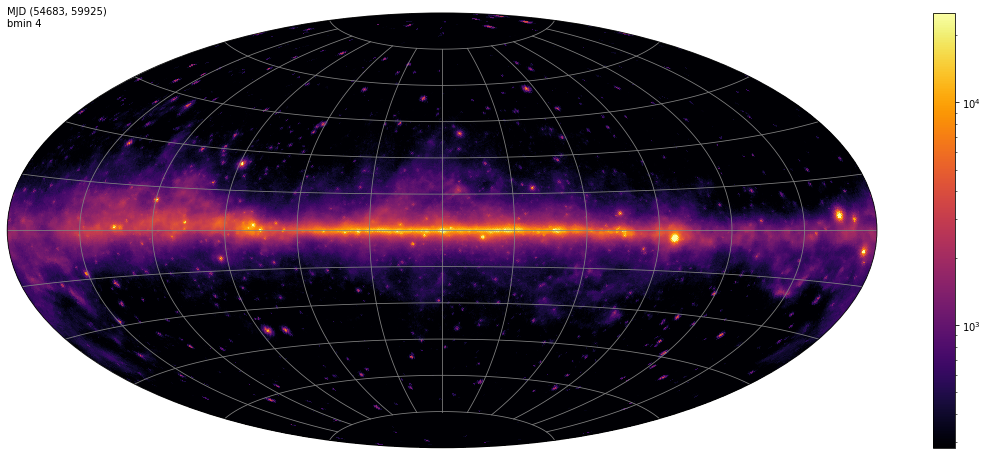 </figure>

### Individual sources: ZEA projections
<figure style="margin-left: 25px" title="Figure 2">   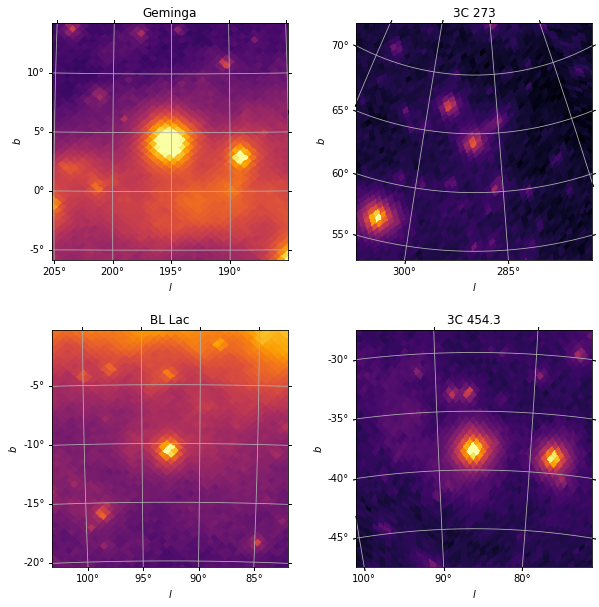 </figure>


In [13]:
#| code-fold: true
hpm = None

@ipynb_doc
def all_sky_count_map(bmin=4, nside=128, pct=(50, 99.98)):
    """
    ## Count plots with the full data set
    
    Time to extract data: {elapsed}
    
    Data set: from {start} to {stop}.
    
    Plotted with nside={nside}, band index >= {bmin}, {photon_count:,} total photons
    
    Note that value limits, {vlim}, correspond to specified percentiles {pct}.
    
    ### All-sky: AIT projection
    {fig1}
    
    ### Individual sources: ZEA projections
    {fig2}
    """
    global hpm # save this for subsquent demos
    # from wtlike.exposure import WeightedAeff
    dvall = DataView(nside=nside, bmin=bmin)
    a, b = dvall.time_range
    start, stop = UTC(a)[:10], UTC(b)[:10]
    
    with Timer() as elapsed:
        cntmap = dvall.count_map() #beam_window=WeightedAeff(Config(), spectrum=None).beam_window() )
   
    photon_count = sum(cntmap)
    vlim = np.percentile(cntmap, pct).round()

    hpm = HPmap(cntmap, f'MJD {dvall.time_range}\nbmin {bmin}',
              unit=f'counts per nside={nside} pixel') 
    
    fig1 = hpm.ait_plot(log=True, tick_labels=False, pixelsize=0.2, figsize=(20,8.),
            vlim=vlim )
    
    fig2 = plt.figure(figsize=(10,10))
    plt.subplots_adjust(wspace=0.2, hspace=0.3)
    kw = dict( fig=fig2, size=20,  colorbar=False, log=True, vmin=1e2, vmax=1e4, cmap='inferno')
    for i,name in enumerate(['Geminga','3C 273', 'BL Lac', '3C 454.3']):
         hpm.zea_plot(name, title=name, axpos=221+i, **kw)
        
    return locals()

if valid: all_sky_count_map()

### Demonstrate SquareWCS

This looks at a region of the all-sky count map generated above.

Start with  a $90^\circ$ plot in Galactic coordinates, centered on the source "Crab pulsar".

The `SquareWCS.plot` function is called with a callback specified by a kwarg `annotator`.
Here the `annotate`  function identifies Geminga and the Crab.
<figure style="margin-left: 25px" title="Figure 1">   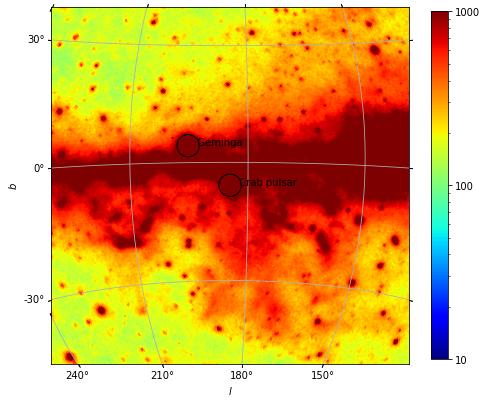 </figure>

Repeat, using the equatorial "fk5" frame for this one.
<figure style="margin-left: 25px" title="Figure 2">   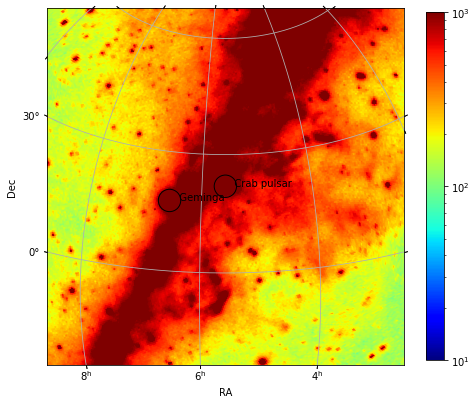 </figure>


In [14]:
#| code-fold: true

@ipynb_doc
def squaremap_demo(name, hpmap, size, vmin=10, vmax=1000):
    r"""
    ### Demonstrate SquareWCS
    
    This looks at a region of the all-sky count map generated above.
    
    Start with  a ${size}^\circ$ plot in Galactic coordinates, centered on the source "{name}".
    
    The `SquareWCS.plot` function is called with a callback specified by a kwarg `annotator`.
    Here the `annotate`  function identifies Geminga and the Crab.
    {fig1}
    
    Repeat, using the equatorial "fk5" frame for this one.
    {fig2}
    """

    sc = findsource(name, gal=True)

    swcs = SquareWCS(sc, size=90)

    def annotate(ax, frame):
        
        
        def source_lonlat(name, gal=True):            
            sky = findsource(name, gal=gal)
            if gal: return sky.galactic.l.deg, sky.galactic.b.deg
            return sky.ra.deg, sky.dec.deg
        
        tf =ax.get_transform(frame) # need the transformation from pixel to world
        for name in ['Geminga', 'Crab pulsar']:
            glb = source_lonlat(name, gal=frame=='galactic')
            ax.scatter(*glb , transform=tf, s=500, edgecolor='black', facecolor='none') 
            ax.text(*glb, '   '+name, color='black', transform=tf);

    cb_kw = dict(ticks = [0.1, 1, 10, 100, 1000],
                ticklabels='0.1 1 10 100 1000'.split(), shrink=0.8)
    
    fig1 = swcs.plot_map(hpmap,  log=True, vmin=vmin, vmax=vmax, unit='counts/pixel',
              cb_kw=cb_kw, annotator = annotate)
    
    swcsc = SquareWCS(sc.fk5, size=90)

    fig2 = swcsc.plot_map(hpmap, log=True, vmin=vmin, vmax=vmax, unit='counts/pixel',
          cb_kw=cb_kw, annotator=annotate)
    return locals()

if valid and hpm is not None: squaremap_demo('Crab pulsar', hpmap=hpm.map, size=90, fignum=1)

In [15]:
show_doc(SquareWCS)
show_doc(SquareWCS.plot_map, title_level=3)

---

### SquareWCS.plot_map

>      SquareWCS.plot_map (hmap, fig=None, axpos=111, figsize=(8, 8), log=False,
>                          cmap='jet', colorbar=True, unit='', vmin=None,
>                          vmax=None, cb_kw={}, annotator=None, title=None,
>                          **kwargs)

Plot a map

- hmap -- a HEALPix map
- fig  [None] -- a Figure

In [16]:
#| export

def draw_map(mapper, time_range, name='', show_sun=False, sigma=0,
                figsize=(9,4), label='', fignum=1, **kwargs):

    """Draw an aitoff map.

    - mapper : the HEALPix map, or a function of a (start,stop) time range that returns one
    - time_range : (start,stop) tuple
    - name ['']: name to give to the map which will be drawn in UL corner
    - label ['']: text to draw in LL corner for time interval, e.g., month number
    - sigma [0]: smoothing parameter (degrees)
    - show_sun [False] : flag to show the sun path
    - utc_flage [True] : show progress bar in UTC, else MJD
    - ** kwargs : pass to the ait_plot function, e.g. vmin, vmax log, colorbar, title
    """
    from wtlike.config import first_data, MJD

    def sun_dir(mjd):
        """The sun direction in galactic coordinates
        """
        from astropy.coordinates import get_sun, SkyCoord
        from astropy.time import Time
        s =  get_sun(Time(mjd, format='mjd'))
        return SkyCoord(s.ra, s.dec, frame='fk5').galactic

    # set up the figure and an aitoff Axes
    fig = plt.figure(figsize=figsize, num=fignum)
    ax1 = fig.add_axes([0.10,0.2,0.9,0.9], projection='aitoff')
    kw = dict(log=False, tick_labels=False, vmin=None, vmax=None, title='', colorbar=True)
    kw.update(**kwargs)
    hpm=HPmap( mapper(time_range) if callable(mapper) else mapper, name, sigma=sigma)
    hpm.ait_plot(  ax=ax1,  **kw);

    if show_sun:
        sd = sun_dir(np.linspace(*time_range, num=100))
        l = sd.l.radian
        l[l>np.pi] -= 2*np.pi
        sdf = pd.DataFrame(dict(l=-l, b=sd.b.radian)).sort_values('l')
        ax1.plot(sdf.l, sdf.b, '-', color='yellow')

    # set up a secod Axes object to show the time range
    ax2 = fig.add_axes([0.35, 0.1, 0.55, 0.11])
    yrs = list(range(2008,2024,2))

    ax2.axvspan(*time_range, color='orange')
    ax2.axvspan(MJD('2008'), first_data, color='lightgrey')
    yrs = [str(yr) for yr in range(2008,2024, 2)]
    ax2.set( xlim=(first_data, MJD('now')), ylim=(0,120), yticks=[], aspect=1,
            xticks=[MJD(yr) for yr in yrs],
            xticklabels=yrs,);
    if label: fig.text(0.33, 0.15, label,fontsize=14, ha='right')
    return fig

In [17]:
show_doc(draw_map, title_level=2)

---

## draw_map

>      draw_map (mapper, time_range, name='', show_sun=False, sigma=0,
>                figsize=(9, 4), label='', fignum=1, **kwargs)

Draw an aitoff map.

- mapper : the HEALPix map, or a function of a (start,stop) time range that returns one
- time_range : (start,stop) tuple
- name ['']: name to give to the map which will be drawn in UL corner
- label ['']: text to draw in LL corner for time interval, e.g., month number
- sigma [0]: smoothing parameter (degrees)
- show_sun [False] : flag to show the sun path
- utc_flage [True] : show progress bar in UTC, else MJD
- ** kwargs : pass to the ait_plot function, e.g. vmin, vmax log, colorbar, title

## Livetime demo

Demonstrate the code to generate a 30-day map of livetime.
To generate an animation:
```
from wtlike.config import FermiMonth
p = Path('./livetime')
for k,t in  enumerate(FermiMonth()):

    filename = p/f'month_{k:03d}.png'
    fig =  make_ltmap(t, vmin=0, vmax=200, colorbar=False);
    fig.text(0.22,0.14, f'month {k+1}', fontsize=12)
    fig.savefig(filename, bbox_inches='tight')
    fig.clear()
```

The following command will make an animated gif
```
ffmpeg -i livetime/month_%03d.png -loop -framerate 1 monthly_livetime.gif
```
The framerate (frames/sec) does not seem to work

__First and last months__
The orange band is the path of the Sun during the 30 days.
<figure style="margin-left: 25px" title="Figure 1">   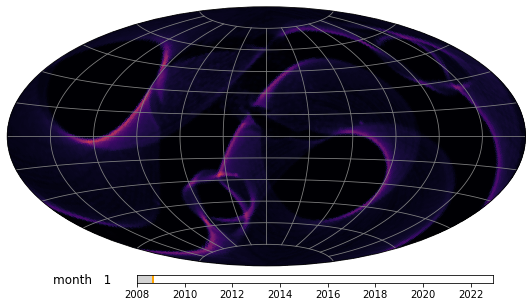 </figure>
<figure style="margin-left: 25px" title="Figure 2">   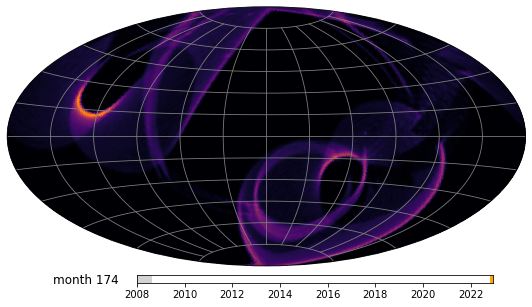 </figure>


In [18]:
#| code-fold: true
@ipynb_doc
def livetime_demo():
    """
    ## Livetime demo
    
    Demonstrate the code to generate a 30-day map of livetime.
    To generate an animation:
    ```
    from wtlike.config import FermiMonth
    p = Path('./livetime')
    for k,t in  enumerate(FermiMonth()):

        filename = p/f'month_{k:03d}.png'
        fig =  make_ltmap(t, vmin=0, vmax=200, colorbar=False);
        fig.text(0.22,0.14, f'month {k+1}', fontsize=12)
        fig.savefig(filename, bbox_inches='tight')
        fig.clear()
    ```
    
    The following command will make an animated gif
    ```
    ffmpeg -i livetime/month_%03d.png -loop -framerate 1 monthly_livetime.gif
    ```
    The framerate (frames/sec) does not seem to work
    
    __First and last months__
    The orange band is the path of the Sun during the 30 days.
    {fig1}
    {fig2}
    """
    from wtlike.config import FermiMonth
    fm = FermiInterval(30)

    def get_livetime(time_range):
        return DataView(time_range).livetime_map(sigma=2)
    
    def make_month(k):        
        fig =  draw_map(get_livetime, fm[k], fignum=k,
                      vmin=0, vmax=200, colorbar=False);
        month = k+1 if k>=0 else len(fm)+k+1
        fig.text(0.22,0.14, f'month {month:3}', fontsize=12)
        return fig
    fig1 = make_month(0)
    fig2 = make_month(-1)
    return locals()


if valid: livetime_demo()

## Convolution demo
        Convolve the map with a "beam", or PSF

        - beam_window: Legendre coefficients or None. For Fermi aeff, use
                exposure.WeightedAeff(Config(), spectrum=None).beam_window() 
        - sigma  Gaussian sigma in degrees

        

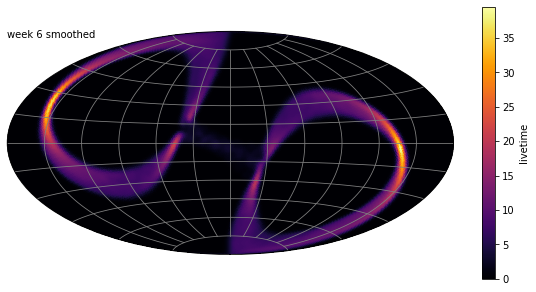

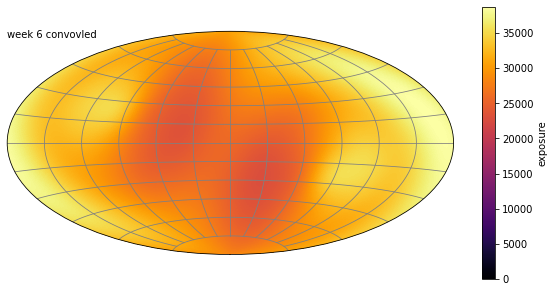

In [19]:
#| include: false
if valid:
    display_markdown("""## Convolution demo
        Convolve the map with a "beam", or PSF

        - beam_window: Legendre coefficients or None. For Fermi aeff, use
                exposure.WeightedAeff(Config(), spectrum=None).beam_window() 
        - sigma  Gaussian sigma in degrees

        """)
    def convolve(self, beam_window=None, sigma=0): #aeff_func):
        import healpy
        return healpy.alm2map(
            healpy.smoothalm( healpy.map2alm(self.map), 
                              sigma=np.radians(sigma), 
                              beam_window=beam_window
                            ),
            nside=self.nside
            )  
    from wtlike.exposure import WeightedAeff
    fermiweek = FermiInterval(7)
    aeff_bw = WeightedAeff().beam_window() 
    ltmap = HPmap(DataView(fermiweek[6]).livetime_map(), 'week 6')

    ait_kw = dict(colorbar=True,vmin=0, figsize=(10,5), tick_labels=False)
    HPmap(convolve(ltmap, None, 2), 'week 6 smoothed', ).ait_plot(fignum=1,unit='livetime', **ait_kw);
    HPmap(convolve(ltmap, aeff_bw), 'week 6 convovled',).ait_plot(fignum=2,unit='exposure', **ait_kw);

In [20]:
#| include: false
import datetime
display_markdown(f'# Finish build: {str(datetime.datetime.now())[:16]}')
from nbdev import nbdev_export
nbdev_export()
!date

# Finish build: 2022-12-11 14:56

Sun Dec 11 14:56:11 PST 2022
